### Experiments

In [1]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import PIL
import os


In [2]:
"""
Directory Structure : 
data/
    Images/
        img_dir/
            train/
                00000000.jpg
                00000001.jpg
                ...
            test/
                00000000.jpg
        ann_dir/
            train/
                00000000.png
                00000001.png
                ...
            test/
                00000000.png
                00000001.png
                ...

"""

'\nDirectory Structure : \ndata/\n    Images/\n        img_dir/\n            train/\n                00000000.jpg\n                00000001.jpg\n                ...\n            test/\n                00000000.jpg\n        ann_dir/\n            train/\n                00000000.png\n                00000001.png\n                ...\n            test/\n                00000000.png\n                00000001.png\n                ...\n\n'

(-0.5, 511.5, 469.5, -0.5)

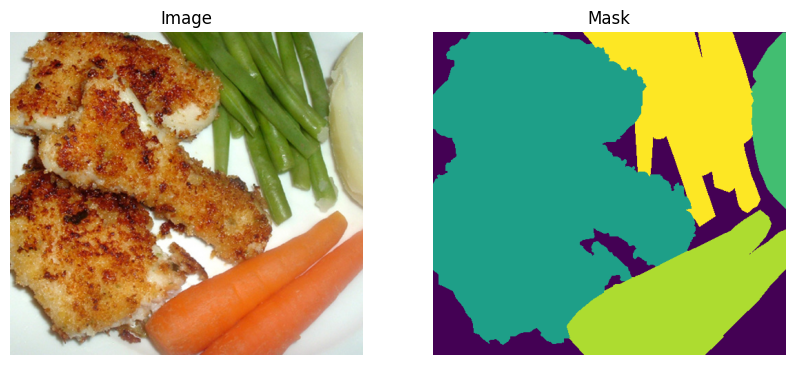

In [56]:
# Creating DataLoader for the dataset

class FoodSegDataset(torch.utils.data.Dataset):
    def __init__(self, base_dir, mode='train', transforms=None):
        self.base_dir = base_dir
        self.mode = mode  # 'train' or 'test'
        
        self.img_dir = os.path.join(base_dir, "Images", "img_dir", mode)
        self.ann_dir = os.path.join(base_dir, "Images", "ann_dir", mode)

        self.transforms = transforms
        
        self.images = os.listdir(self.img_dir)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.images[idx])
        ann_name = os.path.join(self.ann_dir, self.images[idx].replace('.jpg', '.png'))  # ensure extension matches
        
        image = PIL.Image.open(img_name).convert("RGB")
        annotation = PIL.Image.open(ann_name).convert("L")
        
        if self.transforms:
            image = self.transforms(image)
            annotation = self.transforms(annotation)
            
        return image, annotation
    
    
data = FoodSegDataset(
    base_dir="/home/krrish/home/desktop/sensor-behaviour/data",
    mode='train',)

image, mask = data[1]
image = np.array(image)
mask = np.array(mask)

fig, axis = plt.subplots(1, 2, figsize=(10, 5))
axis[0].imshow(image)
axis[0].set_title("Image")
axis[0].axis('off')
axis[1].imshow(mask)
axis[1].set_title("Mask")
axis[1].axis('off')

In [57]:
def data_loaders(base_dir, batch_size=32, num_workers=4, validation_split=0.1):
        
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])
        
        # Create the dataset
        train_dataset = FoodSegDataset(base_dir, mode='train', transforms=transform)
        test_dataset = FoodSegDataset(base_dir, mode='test', transforms=transform)
        
        # Train Validation Split
        train_size = int((1 - validation_split) * len(train_dataset))
        val_size = len(train_dataset) - train_size
        
        train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
        
        # DataLoaders 
        train_loader = torch.utils.data.DataLoader(
            train_dataset, 
            batch_size=batch_size, 
            shuffle=True, 
            num_workers=num_workers
        )
        
        val_loader = torch.utils.data.DataLoader(
            val_dataset, 
            batch_size=batch_size, 
            shuffle=False, 
            num_workers=num_workers
        )
        
        test_loader = torch.utils.data.DataLoader(
            test_dataset, 
            batch_size=batch_size, 
            shuffle=False, 
            num_workers=num_workers
        )
        
        print(f"Train dataset size: {len(train_dataset)}")
        print(f"Validation dataset size: {len(val_dataset)}")
        print(f"Test dataset size: {len(test_dataset)}")
        
        return train_loader, val_loader, test_loader

In [58]:
base_dir = "/home/krrish/home/desktop/sensor-behaviour/data"
train_loader, val_loader, test_loader = data_loaders(base_dir = base_dir)

Train dataset size: 4484
Validation dataset size: 499
Test dataset size: 2135


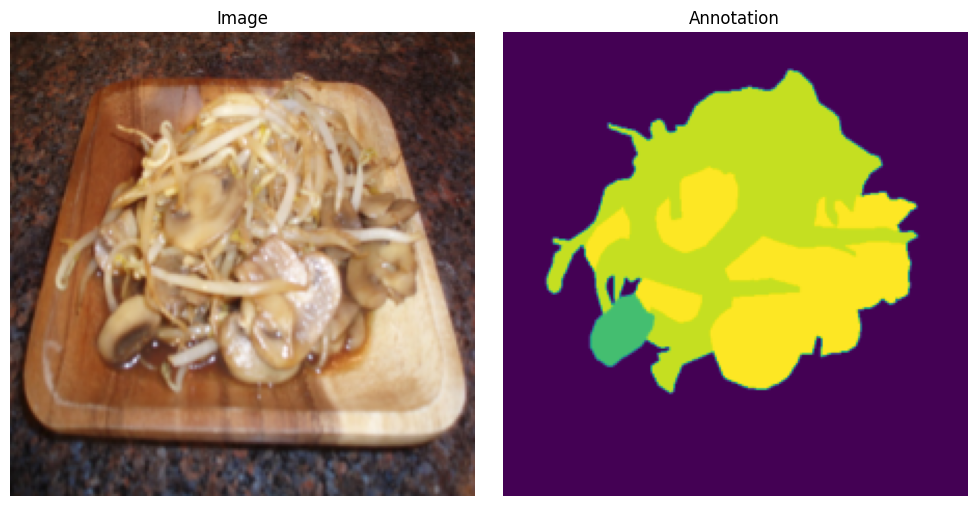

In [61]:
image, annotation = next(iter(train_loader))
fig, axis = plt.subplots(1, 2, figsize=(10, 5))

# For RGB image: transpose from (3, 224, 224) to (224, 224, 3)
axis[0].imshow(image[1].permute(1, 2, 0).numpy())
axis[0].set_title("Image")
axis[0].axis('off')

# For grayscale annotation: squeeze the channel dimension (1, 224, 224) to (224, 224)
axis[1].imshow(annotation[1].permute(1,2,0).numpy())
axis[1].set_title("Annotation")
axis[1].axis('off')

plt.tight_layout()
plt.show()

In [62]:
# Model
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class UnetPlus(nn.Module):
    def __init__(self, n_classes=103, filters=[64,128,256,512,512]):
        super().__init__()
        
        # Encoder
        self.conv0_0 = ConvBlock(3, filters[0])
        self.pool0 = nn.MaxPool2d(2)
        self.conv1_0 = ConvBlock(filters[0], filters[1])
        self.pool1 = nn.MaxPool2d(2)
        self.conv2_0 = ConvBlock(filters[1], filters[2])
        self.pool2 = nn.MaxPool2d(2)
        self.conv3_0 = ConvBlock(filters[2], filters[3])
        self.pool3 = nn.MaxPool2d(2)
        self.conv4_0 = ConvBlock(filters[3], filters[4])

        # Decoder
        self.conv0_1 = ConvBlock(filters[0]+filters[1], filters[0])
        self.conv1_1 = ConvBlock(filters[1]+filters[2], filters[1])
        self.conv2_1 = ConvBlock(filters[2]+filters[3], filters[2])
        self.conv3_1 = ConvBlock(filters[3]+filters[4], filters[3])

        self.conv0_2 = ConvBlock(filters[0]*2 + filters[1], filters[0])
        self.conv1_2 = ConvBlock(filters[1]*2 + filters[2], filters[1])
        self.conv2_2 = ConvBlock(filters[2]*2 + filters[3], filters[2])

        self.conv0_3 = ConvBlock(filters[0]*3 + filters[1], filters[0])
        self.conv1_3 = ConvBlock(filters[1]*3 + filters[2], filters[1])

        self.conv0_4 = ConvBlock(filters[0]*4 + filters[1], filters[0])

        self.final = nn.Conv2d(filters[0], n_classes, 1)

    def forward(self, x):
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool0(x0_0))
        x2_0 = self.conv2_0(self.pool1(x1_0))
        x3_0 = self.conv3_0(self.pool2(x2_0))
        x4_0 = self.conv4_0(self.pool3(x3_0))

        x0_1 = self.conv0_1(torch.cat([x0_0, F.interpolate(x1_0, x0_0.size()[2:], mode='bilinear', align_corners=False)],1))
        x1_1 = self.conv1_1(torch.cat([x1_0, F.interpolate(x2_0, x1_0.size()[2:], mode='bilinear', align_corners=False)],1))
        x2_1 = self.conv2_1(torch.cat([x2_0, F.interpolate(x3_0, x2_0.size()[2:], mode='bilinear', align_corners=False)],1))
        x3_1 = self.conv3_1(torch.cat([x3_0, F.interpolate(x4_0, x3_0.size()[2:], mode='bilinear', align_corners=False)],1))

        # Skip connectionss
        x0_2 = self.conv0_2(torch.cat([
            x0_0, x0_1, F.interpolate(x1_1, x0_0.size()[2:], mode='bilinear', align_corners=False)
        ],1))

        x1_2 = self.conv1_2(torch.cat([
            x1_0, x1_1, F.interpolate(x2_1, x1_0.size()[2:], mode='bilinear', align_corners=False)
        ],1))

        x2_2 = self.conv2_2(torch.cat([
            x2_0, x2_1, F.interpolate(x3_1, x2_0.size()[2:], mode='bilinear', align_corners=False)
        ],1))

        x0_3 = self.conv0_3(torch.cat([
            x0_0, x0_1, x0_2, F.interpolate(x1_2, x0_0.size()[2:], mode='bilinear', align_corners=False)
        ],1))

        x1_3 = self.conv1_3(torch.cat([
            x1_0, x1_1, x1_2, F.interpolate(x2_2, x1_0.size()[2:], mode='bilinear', align_corners=False)
        ],1))

        x0_4 = self.conv0_4(torch.cat([
            x0_0, x0_1, x0_2, x0_3, F.interpolate(x1_3, x0_0.size()[2:], mode='bilinear', align_corners=False)
        ],1))

        out = self.final(x0_4)
        out = F.softmax(out, dim=1)
        return out

In [63]:
class FoodSegmentation(nn.Module):
    def __init__(self, n_classes = 104, lr = 1e-4, base_dir = "/home/krrish/home/desktop/sensor-behaviour", epochs = 10, batch_size = 16):
        
        super().__init__()
        
        self.n_classes = n_classes
        self.model = UnetPlus(n_classes=n_classes).to('cuda' if torch.cuda.is_available() else 'cpu')

        self.parameters = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        
        # Training Parameters
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        
        # Base Directory
        self.base_dir = base_dir
        self.data_dir = os.path.join(base_dir, "data")
        self.model_dir = os.path.join(base_dir, "saved", "model")
        
        # Data Loaders
        self.train_loader, self.val_loader, self.test_loader = data_loaders(base_dir=self.data_dir, validation_split=0.1, batch_size=self.batch_size)

        self.loss = nn.CrossEntropyLoss() 
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        
        print(f"Total parameters in the model: {self.parameters}")
        
    def forward(self, x):
        return self.model(x)
    
    def train_step(self, image, mask):
        self.model.train()
        self.optimizer.zero_grad()
        
        # Move data to device
        image = image.to('cuda' if torch.cuda.is_available() else 'cpu')
        mask = mask.to('cuda' if torch.cuda.is_available() else 'cpu')
        
        outputs = self.forward(image)
        loss = self.loss(outputs, mask)
        
        loss.backward()
        self.optimizer.step()
        
        return loss.item()
    
    def eval_step(self, image, mask):
        self.model.eval()
        with torch.no_grad():
            
            # Move data to device
            image = image.to('cuda' if torch.cuda.is_available() else 'cpu')
            mask = mask.to('cuda' if torch.cuda.is_available() else 'cpu')
            
            outputs = self.forward(image)
            loss = self.loss(outputs, mask)

        return loss.item()
    
    def train(self):
        for epoch in range(self.epochs):
            
            train_loss = 0.0
            for images, masks in self.train_loader:
                loss = self.train_step(images, masks)
                train_loss += loss
                
            train_loss /= len(self.train_loader)
            print(f"Epoch [{epoch+1}/{self.epochs}], Train Loss: {train_loss:.4f}")
            
            val_loss = 0.0
            for images, masks in self.val_loader:
                loss = self.eval_step(images, masks)
                val_loss += loss
                
            val_loss /= len(self.val_loader)
            print(f"Epoch [{epoch+1}/{self.epochs}], Validation Loss: {val_loss:.4f}")
            
        torch.save(self.model.state_dict(), os.path.join(self.model_dir, "model.pth"))
        print("Training complete.")


In [68]:
noice = FoodSegmentation(n_classes=104, epochs=2)

noice.train()

Train dataset size: 4484
Validation dataset size: 499
Test dataset size: 2135
Total parameters in the model: 24836776


RuntimeError: only batches of spatial targets supported (3D tensors) but got targets of size: : [16, 1, 224, 224]

In [10]:
model = FoodSegmentation(n_classes=104, epochs=2, batch_size=8)
model.model.load_state_dict(torch.load(os.path.join(model.model_dir, "model.pth")))

Train dataset size: 4484
Validation dataset size: 499
Test dataset size: 2135
Total parameters in the model: 24836776


<All keys matched successfully>

In [64]:
images, masks = next(iter(model.train_loader))
predictions = model(images.to('cuda' if torch.cuda.is_available() else 'cpu'))

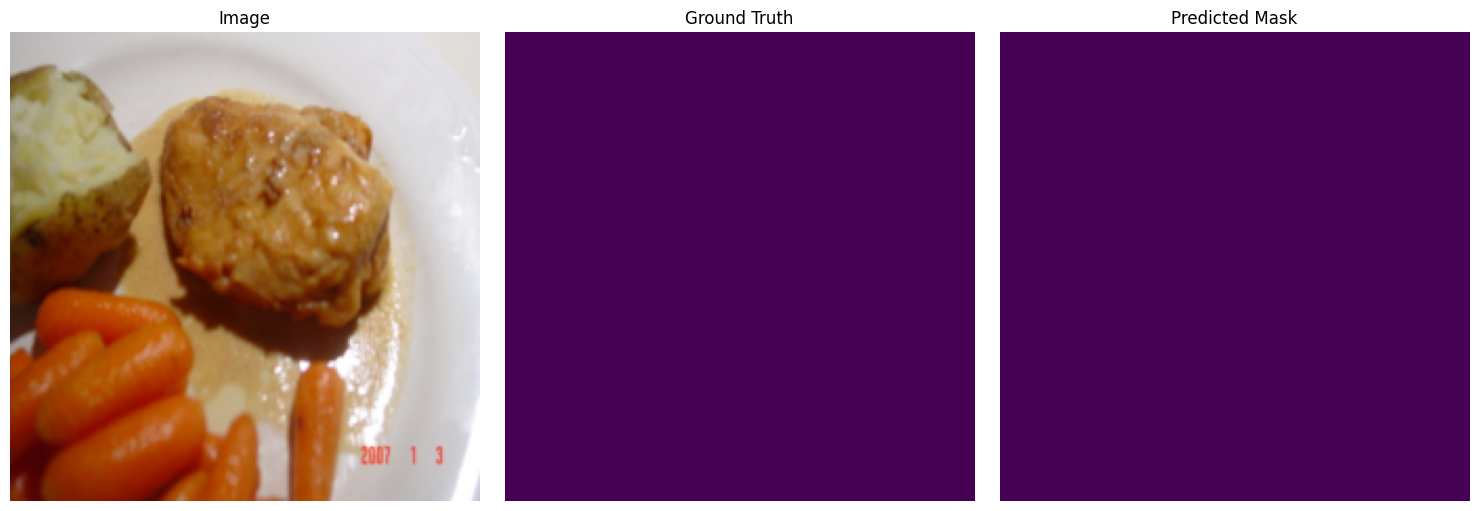

In [67]:
fig, axis = plt.subplots(1, 3, figsize=(15, 5))

# For RGB image: transpose from (3, 224, 224) to (224, 224, 3)
axis[0].imshow(images[1].permute(1, 2, 0).numpy())
axis[0].set_title("Image")
axis[0].axis('off')

# For grayscale annotation: squeeze the channel dimension (1, 224, 224) to (224, 224)
axis[1].imshow(masks[1].numpy())
axis[1].set_title("Ground Truth")
axis[1].axis('off')
# For predicted segmentation map: argmax over classes
predicted_mask = predictions[1].argmax(dim=0).cpu().numpy()
axis[2].imshow(predicted_mask)
axis[2].set_title("Predicted Mask")
axis[2].axis('off')

plt.tight_layout()
plt.show()
